## Analiza danych i zbudowanie modeli predykcyjnych

### Piotr Mariusz Kozikowski

---

Na potrzeby zrealizowanej analizy danych, zdecydowano się na wybór zbioru danych dotyczącego przejazdów żółtych taksówek (ang. *yellow taxis*) w Nowym Jorku, obejmującego I kwartał 2024 r. 

#### Import niezbędnych bibliotek do wczytania danych, przeprowadzenia analizy danych i szacowania modeli predykcyjnych

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import plot_utils as pu
import data_utils as du

#### Wczytanie plików w formacie Parquet do ramek danych Pandas

In [2]:
# Wczytanie plików ze zbiorami danych w formacie Parquet
file_name = "data/yellow_tripdata_2024-xx.parquet"

# Utworzenie ramek danych poprzez wczytanie wybranych plików z danymi
df_1 = pd.read_parquet(file_name.replace("xx", "01"))
df_2 = pd.read_parquet(file_name.replace("xx", "02"))
df_3 = pd.read_parquet(file_name.replace("xx", "03"))

# Połączenie powstałych ramek danych w jedną ramkę
df = pd.concat([df_1, df_2, df_3])

# Zresetowanie indeksu w ramce danych w celu zachowania jednolitości
df.reset_index(inplace=True, drop=True)

In [30]:
# Wyświetlenie pierwszych pięciu wierszy we wczytanej ramce danych
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,pickup_minute,pickup_second,dropoff_day,dropoff_weekday,dropoff_month,dropoff_year,dropoff_hour,dropoff_minute,dropoff_second,seconds_between_dates
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,186,79,2,17.7,1.0,...,57,55,1,0,1,2024,1,17,43,1188.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,140,236,1,10.0,3.5,...,3,0,1,0,1,2024,0,9,36,396.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,236,79,1,23.3,3.5,...,17,6,1,0,1,2024,0,35,1,1075.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,79,211,1,10.0,3.5,...,36,38,1,0,1,2024,0,44,56,498.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,211,148,1,7.9,3.5,...,46,51,1,0,1,2024,0,52,57,366.0


In [4]:
# Wyświetlenie ostatnich pięciu wierszy we wczytanej ramce danych
df.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
9554773,2,2024-03-31 23:16:45,2024-03-31 23:29:20,NaN,4.27,NaN,None,130,218,0,14.27,0.0,0.5,0.00,0.0,1.0,15.77,NaN,NaN
9554774,1,2024-03-31 23:29:28,2024-03-31 23:43:47,NaN,0.00,NaN,None,79,100,0,14.00,1.0,0.5,3.80,0.0,1.0,24.80,NaN,NaN
9554775,2,2024-03-31 23:15:00,2024-03-31 23:47:29,NaN,6.44,NaN,None,63,181,0,30.00,0.0,0.5,0.00,0.0,1.0,31.50,NaN,NaN
9554776,2,2024-03-31 23:27:53,2024-03-31 23:45:44,NaN,3.88,NaN,None,161,148,0,22.32,0.0,0.5,5.26,0.0,1.0,31.58,NaN,NaN
9554777,2,2024-03-31 23:10:50,2024-03-31 23:31:59,NaN,7.39,NaN,None,95,7,0,31.47,0.0,0.5,0.00,0.0,1.0,32.97,NaN,NaN


In [5]:
vendor_names = {1: 'CMT', 2: 'CM', 6: 'MT', 7: 'Helix'}
df['VendorName'] = df['VendorID'].replace(vendor_names)

In [6]:
print(df['VendorName'].unique())

['CM' 'CMT' 'MT']


#### Statystyki opisowe i podstawowe informacje o analizowanym zbiorze danych

In [7]:
# Wyświetlenie informacji o nazwach kolumn oraz ich typach danych w ramce danych
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9554778 entries, 0 to 9554777
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [8]:
numeric_col_list = [col for col in df.columns if col not in ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
                                                             'payment_type']]

In [9]:
# Wyświetlenie podstawowych statystyk opisowych zbioru danych
df.loc[:, numeric_col_list].describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,9554778,9554778,8.802816e+06,9.554778e+06,9.554778e+06,9.554778e+06,9.554778e+06,9.554778e+06,9.554778e+06,9.554778e+06,9.554778e+06,8.802816e+06,8.802816e+06
mean,2024-02-17 17:20:27.204719,2024-02-17 17:36:34.800669,1.334410e+00,4.042286e+00,1.832512e+01,1.416683e+00,4.831806e-01,3.271080e+00,5.263560e-01,9.750437e-01,2.686540e+01,2.258098e+00,1.377972e-01
min,2002-12-31 22:17:10,2002-12-31 22:42:24,0.000000e+00,0.000000e+00,-9.990000e+02,-7.500000e+00,-5.000000e-01,-3.000000e+02,-8.430000e+01,-1.000000e+00,-1.000000e+03,-2.500000e+00,-1.750000e+00
25%,2024-01-26 09:55:41.250000,2024-01-26 10:12:00.250000,1.000000e+00,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.547000e+01,2.500000e+00,0.000000e+00
50%,2024-02-18 15:38:32.500000,2024-02-18 15:55:02.500000,1.000000e+00,1.700000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.650000e+00,0.000000e+00,1.000000e+00,2.020000e+01,2.500000e+00,0.000000e+00
75%,2024-03-11 11:59:11.750000,2024-03-11 12:16:17,1.000000e+00,3.190000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.120000e+00,0.000000e+00,1.000000e+00,2.892000e+01,2.500000e+00,0.000000e+00
max,2024-04-01 00:34:55,2024-04-02 18:08:46,9.000000e+00,3.127223e+05,9.792000e+03,1.425000e+01,3.584000e+01,9.999900e+02,1.630000e+02,1.000000e+00,9.792000e+03,2.500000e+00,1.750000e+00
std,NaN,NaN,8.409249e-01,2.654783e+02,1.854497e+01,1.804238e+00,1.190495e-01,3.927616e+00,2.124506e+00,2.203429e-01,2.305019e+01,8.254055e-01,4.831947e-01


**Komentarz:** Wśród wartości w kolumnie *fare_amount* pojawiają się wartości ujemne, które odpowiadają zwrotom kosztów przejazdu pasażerom ze względu na różne przyczyny (np. odwołanie przejazdu, niepoprawna pobrana kwota). Analogicznie w przypadku kolumn *extra*, *mta_tax*, *tip_amount*, *tolls_amount*, *improvement_surcharge* i *congestion_surcharge*. Stąd też zdecydowano, aby kwoty te zamienić na wartości dodatnie poprzez użycie wartości bezwzględnej. 

In [10]:
neg_val_cols = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']

for col in neg_val_cols:
    df[col] = df[col].abs()

#### Utworzenie pomocniczych kolumn zawierających szczegółowe informacje o datach odbioru i wysadzenia pasażerów

In [11]:
# Utworzenie pomocniczych kolumn zawierających rozdzielone informacje o czasie na podstawie
# dat odbioru i wysadzenia pasażerów
for col_name in ['pickup', 'dropoff']:
    df[f'{col_name}_day'] = df[f'tpep_{col_name}_datetime'].dt.day
    df[f'{col_name}_weekday'] = df[f'tpep_{col_name}_datetime'].dt.dayofweek
    df[f'{col_name}_month'] = df[f'tpep_{col_name}_datetime'].dt.month
    df[f'{col_name}_year'] = df[f'tpep_{col_name}_datetime'].dt.year
    df[f'{col_name}_hour'] = df[f'tpep_{col_name}_datetime'].dt.hour
    df[f'{col_name}_minute'] = df[f'tpep_{col_name}_datetime'].dt.minute
    df[f'{col_name}_second'] = df[f'tpep_{col_name}_datetime'].dt.second

In [12]:
# Wyświetlenie podstawowych statystyk opisowych zbioru danych po zamianie wartości
df.loc[:, numeric_col_list].describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,9554778,9554778,8.802816e+06,9.554778e+06,9.554778e+06,9.554778e+06,9.554778e+06,9.554778e+06,9.554778e+06,9.554778e+06,9.554778e+06,8.802816e+06,8.802816e+06
mean,2024-02-17 17:20:27.204719,2024-02-17 17:36:34.800669,1.334410e+00,4.042286e+00,1.883008e+01,1.439786e+00,4.949449e-01,3.271626e+00,5.396723e-01,9.993000e-01,2.686540e+01,2.312122e+00,1.442658e-01
min,2002-12-31 22:17:10,2002-12-31 22:42:24,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+03,0.000000e+00,0.000000e+00
25%,2024-01-26 09:55:41.250000,2024-01-26 10:12:00.250000,1.000000e+00,1.000000e+00,9.300000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.547000e+01,2.500000e+00,0.000000e+00
50%,2024-02-18 15:38:32.500000,2024-02-18 15:55:02.500000,1.000000e+00,1.700000e+00,1.302000e+01,1.000000e+00,5.000000e-01,2.650000e+00,0.000000e+00,1.000000e+00,2.020000e+01,2.500000e+00,0.000000e+00
75%,2024-03-11 11:59:11.750000,2024-03-11 12:16:17,1.000000e+00,3.190000e+00,2.120000e+01,2.500000e+00,5.000000e-01,4.120000e+00,0.000000e+00,1.000000e+00,2.892000e+01,2.500000e+00,0.000000e+00
max,2024-04-01 00:34:55,2024-04-02 18:08:46,9.000000e+00,3.127223e+05,9.792000e+03,1.425000e+01,3.584000e+01,9.999900e+02,1.630000e+02,1.000000e+00,9.792000e+03,2.500000e+00,1.750000e+00
std,NaN,NaN,8.409249e-01,2.654783e+02,1.803202e+01,1.785856e+00,5.163190e-02,3.927161e+00,2.121162e+00,2.570371e-02,2.305019e+01,6.590868e-01,4.813030e-01


#### Sprawdzenie, czy w zbiorze danych występują wiersze niemieszczące się w wybranym zakresie czasowym

In [13]:
# Wyszukanie wszystkich wierszy zawierających dane sprzed badanego okresu
df[(df.pickup_year <= 2023) & (df.dropoff_year < 2024)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,pickup_hour,pickup_minute,pickup_second,dropoff_day,dropoff_weekday,dropoff_month,dropoff_year,dropoff_hour,dropoff_minute,dropoff_second
369,2,2023-12-31 23:39:17,2023-12-31 23:42:00,2.0,0.47,1.0,N,90,68,1,...,23,39,17,31,6,12,2023,23,42,0
753,2,2023-12-31 23:41:02,2023-12-31 23:48:03,1.0,0.40,1.0,N,246,246,2,...,23,41,2,31,6,12,2023,23,48,3
3176,2,2023-12-31 23:47:28,2023-12-31 23:57:07,2.0,1.44,1.0,N,68,137,1,...,23,47,28,31,6,12,2023,23,57,7
10915,2,2009-01-01 23:58:40,2009-01-02 00:01:40,1.0,0.46,1.0,N,137,264,2,...,23,58,40,2,4,1,2009,0,1,40
53119,2,2002-12-31 22:59:39,2002-12-31 23:05:41,1.0,0.63,1.0,N,170,170,3,...,22,59,39,31,1,12,2002,23,5,41
53120,2,2002-12-31 22:59:39,2002-12-31 23:05:41,1.0,0.63,1.0,N,170,170,3,...,22,59,39,31,1,12,2002,23,5,41
1230169,2,2009-01-01 23:30:39,2009-01-02 00:01:39,1.0,10.99,1.0,N,237,264,2,...,23,30,39,2,4,1,2009,0,1,39
2558056,2,2009-01-01 00:24:09,2009-01-01 01:13:00,2.0,10.88,1.0,N,138,264,2,...,0,24,9,1,3,1,2009,1,13,0
3145907,2,2008-12-31 22:52:49,2008-12-31 23:04:09,1.0,1.62,1.0,N,141,211,1,...,22,52,49,31,2,12,2008,23,4,9
3863477,2,2009-01-01 00:02:13,2009-01-01 00:48:28,1.0,0.57,1.0,N,79,148,1,...,0,2,13,1,3,1,2009,0,48,28


In [14]:
# Wyświetlenie informacji o liczności wierszy spełniających dany warunek
print("Liczba wierszy dotyczących przejazdów do roku 2009 włącznie:", (df.pickup_year <= 2009).sum())
print("Liczba wierszy dotyczących przejazdów w roku 2023, które nie kończyły się w roku 2024:", ((df.pickup_year >= 2023) & (df.dropoff_year < 2024)).sum())

Liczba wierszy dotyczących przejazdów do roku 2009 włącznie: 9
Liczba wierszy dotyczących przejazdów w roku 2023, które nie kończyły się w roku 2024: 3


**Komentarz:** Wśród zebranych danych dotyczących przejazdów taksówkami w Nowym Jorku w miesiącach **styczeń - marzec 2024 r.** pojawiły się również dane
dotyczące przejazdów w latach **2002, 2008 i 2009** (*łącznie: 9*). Ponadto, w zbiorze danych znajdują się także informacje o przejazdach w ostatni dzień roku **2023**, czyli w Sylwestra, również te kończące się tego samego dnia (*łącznie: 3*). W związku z tym, zdecydowano się usunąć wspomniane wiersze, aby nie zaburzały dalszej części analizy.

In [15]:
# Usunięcie wierszy zawierających przejazdy sprzed 2024 r. (poza tymi z przełomu lat 2023 i 2024)
df = df[~((df.pickup_year <= 2023) & (df.dropoff_year < 2024))]

# Weryfikacja poczynionych zmian
print("Pierwsza data odbioru pasażera w zbiorze danych:", df.tpep_pickup_datetime.min())
print("Pierwsza data wysadzenia pasażera w zbiorze danych:", df.tpep_dropoff_datetime.min())

Pierwsza data odbioru pasażera w zbiorze danych: 2023-12-31 23:49:12
Pierwsza data wysadzenia pasażera w zbiorze danych: 2024-01-01 00:00:28


In [16]:
passenger_sum = df.groupby('VendorName', as_index=False)['passenger_count'].sum()
passenger_sum

,VendorName,passenger_count
0,CM,9227946.0
1,CMT,2518604.0
2,MT,0.0


**Komentarz:** Zaobserwowano brak informacji o liczbie przewiezionych pasażerów przez firmę *Myle Technologies Inc*, co potwierdza również poniższe wywołanie kodu. W związku, iż brak ten obejmuje cały ustalony zakres czasowy, zdecydowano się na uzupełnienie danych o liczbie pasażerów w oparciu o dane dotyczące pozostałych przewoźników, odwołując się do pokonanego dystansu w trakcie przejazdu (funkcja *estimate_passenger_count*).

In [17]:
df[df['VendorName'] == 'MT']

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,pickup_hour,pickup_minute,pickup_second,dropoff_day,dropoff_weekday,dropoff_month,dropoff_year,dropoff_hour,dropoff_minute,dropoff_second
2827331,6,2024-01-01 02:01:50,2024-01-01 02:01:39,NaN,7.46,NaN,None,265,197,0,...,2,1,50,1,0,1,2024,2,1,39
2828143,6,2024-01-01 03:01:46,2024-01-01 03:01:39,NaN,7.65,NaN,None,265,62,0,...,3,1,46,1,0,1,2024,3,1,39
2831527,6,2024-01-01 09:01:16,2024-01-01 09:01:49,NaN,20.16,NaN,None,265,151,0,...,9,1,16,1,0,1,2024,9,1,49
2831545,6,2024-01-01 09:01:55,2024-01-01 10:01:04,NaN,15.50,NaN,None,265,151,0,...,9,1,55,1,0,1,2024,10,1,4
2831631,6,2024-01-01 10:01:43,2024-01-01 10:01:48,NaN,17.83,NaN,None,265,191,0,...,10,1,43,1,0,1,2024,10,1,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9547717,6,2024-03-31 13:03:18,2024-03-31 13:03:07,NaN,15.12,NaN,None,265,89,0,...,13,3,18,31,6,3,2024,13,3,7
9547980,6,2024-03-31 13:03:56,2024-03-31 14:03:30,NaN,12.74,NaN,None,265,131,0,...,13,3,56,31,6,3,2024,14,3,30
9547981,6,2024-03-31 13:03:51,2024-03-31 13:03:34,NaN,1.58,NaN,None,265,148,0,...,13,3,51,31,6,3,2024,13,3,34
9549999,6,2024-03-31 16:03:53,2024-03-31 16:03:51,NaN,13.01,NaN,None,265,216,0,...,16,3,53,31,6,3,2024,16,3,51


In [18]:
df['passenger_count'] = df.apply(
    lambda row: du.estimate_passenger_count(df, row, 'MT'),
    axis=1
)
passenger_sum = df.groupby('VendorName', as_index=False)['passenger_count'].sum()
passenger_sum

,VendorName,passenger_count
0,CM,9227946.0
1,CMT,2518604.0
2,MT,720.0


**Komentarz:** Wykorzystanie zdefiniowanej funkcji pozwoliło na uzupełnienie **720** braków danych w kolumnie *passenger_count*, co w przeliczeniu dało łączną liczbę pasażerów wynoszącą ok. **979** pasażerów w ciągu I kwartału 2024 r.

In [19]:
# Wyświetlenie liczby wszystkich wartości pustych w kolumnach ramki danych
print(df.iloc[:, :-14].isna().sum())

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          751242
trip_distance                 0
RatecodeID               751962
store_and_fwd_flag       751962
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     751962
Airport_fee              751962
VendorName                    0
dtype: int64


In [20]:
passenger_missing_data_pct = (df.loc[:, numeric_col_list].isna().sum()['passenger_count'] / df.shape[0]) * 100
other_missing_data_pct = (df.loc[:, numeric_col_list].isna().sum()['congestion_surcharge'] / df.shape[0]) * 100
missing_data_cols = df.columns[df.isna().sum() > 0].tolist()
missing_data_cols.remove('passenger_count')
print(f"Procent brakujących danych w kolumnie passenger_count wynosi {passenger_missing_data_pct:.2f} %, zaś w kolumnach {', '.join(missing_data_cols)} wynosi on {other_missing_data_pct:.2f} %.")

Procent brakujących danych w kolumnie passenger_count wynosi 7.86 %, zaś w kolumnach RatecodeID, store_and_fwd_flag, congestion_surcharge, Airport_fee wynosi on 7.87 %.


**Komentarz:** Wśród analizowanych danych znajduje się łącznie **751962** pustych wartości w kolumnach *RatecodeID*, *store_and_fwd_flag*,
*congestion_surcharge* i *Airport_fee* oraz **751742** w kolumnie *passenger_count*. Odsetek tych wartości wynosi, odpowiednio, **7,87 %** i **7,86 %**, zatem jest to bardzo mały procent całego zbioru danych (< 10 %). Warto jednak odnotować, że braki te dotyczą również jedynych danych odnośnie przewoźnika *Myle Technologies Inc*, więc na potrzeby dalszej analizy ze zbioru danych wykluczone zostaną kolumny *RatecodeID*, *store_and_fwd_flag*, *congestion_surcharge* oraz *Airport_fee*. W przypadku kolumny *passenger_count*, wiersze z brakującymi danymi zostaną usunięte ze zbioru danych.

In [21]:
df.drop(columns=missing_data_cols, inplace=True)

In [22]:
numeric_col_list

['tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee',
 'VendorName']

In [23]:
for col in ['congestion_surcharge', 'Airport_fee', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'VendorName']:
    numeric_col_list.remove(col)

In [24]:
df.dropna(inplace=True)

In [25]:
print(df.iloc[:, :-14].isna().sum())

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
VendorName               0
dtype: int64


In [26]:
# Wyświetlenie liczby powtarzających się (zduplikowanych) wierszy
print(f"Wśród analizowanych danych znajduje się {df.duplicated().sum()} zduplikowany wiersz.")

Wśród analizowanych danych znajduje się 1 zduplikowany wiersz.


In [27]:
duplicates_all = df[df.duplicated(keep=False)]
duplicates_all

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,pickup_hour,pickup_minute,pickup_second,dropoff_day,dropoff_weekday,dropoff_month,dropoff_year,dropoff_hour,dropoff_minute,dropoff_second
3718872,2,2024-02-08 18:23:50,2024-02-08 18:38:14,1.0,0.81,162,230,1,12.8,2.5,...,18,23,50,8,3,2,2024,18,38,14
3718876,2,2024-02-08 18:23:50,2024-02-08 18:38:14,1.0,0.81,162,230,1,12.8,2.5,...,18,23,50,8,3,2,2024,18,38,14


**Komentarz:** Wśród analizowanych danych znalazł się tylko jeden duplikat wiersza, w którym wszystkie wartości w poszczególnych kolumnach się powtarzają (są to obserwacje oddalone od siebie o 4 miejsca względem indeksu). Z racji specyfiki problemu, czyli analizy przejazdów taksówkami w Nowym Jorku, uzasadnione jest to, aby pozostawić te obserwacje, gdyż możliwe jest zamówienie przejazdu z tego samego miejsca o tym samym czasie do tego samego miejsca przybycia.

In [28]:
df['seconds_between_dates'] = abs((df['tpep_pickup_datetime'] - df['tpep_dropoff_datetime']) / pd.Timedelta(seconds=1))

In [29]:
wrong_dates = (df['tpep_dropoff_datetime'] < df['tpep_pickup_datetime'])

In [30]:
short_time_wrong_dates = wrong_dates & (df['trip_distance'] > 1) & (
        df['seconds_between_dates'] < 60)
df[short_time_wrong_dates]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,pickup_minute,pickup_second,dropoff_day,dropoff_weekday,dropoff_month,dropoff_year,dropoff_hour,dropoff_minute,dropoff_second,seconds_between_dates
2827331,6,2024-01-01 02:01:50,2024-01-01 02:01:39,1.0,7.46,265,197,0,39.22,0.0,...,1,50,1,0,1,2024,2,1,39,11.0
2828143,6,2024-01-01 03:01:46,2024-01-01 03:01:39,1.0,7.65,265,62,0,40.69,0.0,...,1,46,1,0,1,2024,3,1,39,7.0
2836461,6,2024-01-02 16:01:44,2024-01-02 16:01:24,1.0,7.32,265,129,0,44.20,0.0,...,1,44,2,1,1,2024,16,1,24,20.0
2836462,6,2024-01-02 16:01:30,2024-01-02 16:01:19,1.0,9.02,265,95,0,49.82,0.0,...,1,30,2,1,1,2024,16,1,19,11.0
2837265,6,2024-01-03 05:01:56,2024-01-03 05:01:27,1.0,4.63,265,130,0,18.43,0.0,...,1,56,3,2,1,2024,5,1,27,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9546037,6,2024-03-31 10:03:31,2024-03-31 10:03:14,1.0,8.65,265,28,0,40.20,0.5,...,3,31,31,6,3,2024,10,3,14,17.0
9546038,6,2024-03-31 10:03:52,2024-03-31 10:03:36,1.0,3.89,265,28,0,31.20,0.5,...,3,52,31,6,3,2024,10,3,36,16.0
9547717,6,2024-03-31 13:03:18,2024-03-31 13:03:07,1.0,15.12,265,89,0,54.83,0.0,...,3,18,31,6,3,2024,13,3,7,11.0
9547981,6,2024-03-31 13:03:51,2024-03-31 13:03:34,1.0,1.58,265,148,0,22.20,0.0,...,3,51,31,6,3,2024,13,3,34,17.0


In [31]:
df = df[~short_time_wrong_dates]

In [32]:
paid_stop = (df['trip_distance'] == 0) & (df['fare_amount'] > 0) & (df['PULocationID'] == df['DOLocationID'])
df[paid_stop]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,pickup_minute,pickup_second,dropoff_day,dropoff_weekday,dropoff_month,dropoff_year,dropoff_hour,dropoff_minute,dropoff_second,seconds_between_dates
17,2,2024-01-01 00:52:09,2024-01-01 00:52:28,1.0,0.0,237,237,2,3.0,1.0,...,52,9,1,0,1,2024,0,52,28,19.0
111,1,2024-01-01 00:58:50,2024-01-01 01:01:10,1.0,0.0,162,162,1,4.4,3.5,...,58,50,1,0,1,2024,1,1,10,140.0
580,2,2024-01-01 00:04:05,2024-01-01 00:04:11,1.0,0.0,143,143,1,12.2,0.0,...,4,5,1,0,1,2024,0,4,11,6.0
593,1,2024-01-01 00:25:58,2024-01-01 00:27:19,1.0,0.0,114,114,1,10.0,0.0,...,25,58,1,0,1,2024,0,27,19,81.0
709,2,2024-01-01 00:28:27,2024-01-01 00:29:15,4.0,0.0,265,265,1,180.0,0.0,...,28,27,1,0,1,2024,0,29,15,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9128512,2,2024-03-31 23:08:45,2024-03-31 23:09:24,1.0,0.0,249,249,2,3.0,1.0,...,8,45,31,6,3,2024,23,9,24,39.0
9128562,2,2024-03-31 23:14:47,2024-03-31 23:15:11,1.0,0.0,112,112,1,75.0,0.0,...,14,47,31,6,3,2024,23,15,11,24.0
9128566,2,2024-03-31 23:49:14,2024-03-31 23:49:19,2.0,0.0,61,61,1,85.0,0.0,...,49,14,31,6,3,2024,23,49,19,5.0
9128574,2,2024-03-31 23:11:43,2024-03-31 23:12:02,5.0,0.0,142,142,2,3.0,1.0,...,11,43,31,6,3,2024,23,12,2,19.0


In [33]:
df = df[~paid_stop]

In [34]:
paid_no_dist_trip = (df['trip_distance'] == 0) & (df['fare_amount'] > 0) & (df['PULocationID'] != df['DOLocationID']) & (df['tolls_amount'] > 0)
df[paid_no_dist_trip]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,pickup_minute,pickup_second,dropoff_day,dropoff_weekday,dropoff_month,dropoff_year,dropoff_hour,dropoff_minute,dropoff_second,seconds_between_dates
251,1,2024-01-01 00:18:26,2024-01-01 00:52:40,1.0,0.0,222,147,1,52.5,0.00,...,18,26,1,0,1,2024,0,52,40,2054.0
1922,1,2024-01-01 00:38:11,2024-01-01 01:23:26,1.0,0.0,41,188,1,49.5,0.00,...,38,11,1,0,1,2024,1,23,26,2715.0
11223,2,2024-01-01 01:35:00,2024-01-01 02:05:20,1.0,0.0,161,255,1,24.0,1.00,...,35,0,1,0,1,2024,2,5,20,1820.0
20200,2,2024-01-01 03:38:48,2024-01-01 03:39:07,1.0,0.0,164,186,4,100.0,0.00,...,38,48,1,0,1,2024,3,39,7,19.0
23741,1,2024-01-01 05:21:02,2024-01-01 05:45:07,1.0,0.0,263,171,1,34.5,0.00,...,21,2,1,0,1,2024,5,45,7,1445.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9119753,1,2024-03-31 21:07:46,2024-03-31 21:49:01,1.0,0.0,42,89,1,49.5,0.00,...,7,46,31,6,3,2024,21,49,1,2475.0
9120168,1,2024-03-31 21:30:16,2024-03-31 22:27:22,1.0,0.0,151,76,1,65.5,0.00,...,30,16,31,6,3,2024,22,27,22,3426.0
9121209,1,2024-03-31 21:23:20,2024-03-31 22:02:47,1.0,0.0,97,159,1,41.5,0.00,...,23,20,31,6,3,2024,22,2,47,2367.0
9123358,1,2024-03-31 22:22:53,2024-03-31 22:22:53,4.0,0.0,132,264,2,70.0,4.25,...,22,53,31,6,3,2024,22,22,53,0.0


In [36]:
df['trip_distance'] = df.apply(
    lambda row: du.estimate_distance(df, row),
    axis=1
)

In [37]:
df.iloc[:, :-15].describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,8.728302e+06,8728302,8728302,8.728302e+06,8.728302e+06,8.728302e+06,8.728302e+06,8.728302e+06,8.728302e+06,8.728302e+06,8.728302e+06,8.728302e+06,8.728302e+06,8.728302e+06,8.728302e+06
mean,1.759051e+00,2024-02-16 19:58:09.142039,2024-02-16 20:14:23.969294,1.334158e+00,3.439449e+00,1.657582e+02,1.648769e+02,1.210144e+00,1.868827e+01,1.561613e+00,4.963120e-01,3.471393e+00,5.661298e-01,9.996350e-01,2.705741e+01
min,1.000000e+00,2023-12-31 23:49:12,2024-01-01 00:00:28,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+03
25%,2.000000e+00,2024-01-25 16:05:06.250000,2024-01-25 16:23:54.250000,1.000000e+00,1.010000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.548000e+01
50%,2.000000e+00,2024-02-17 02:31:19,2024-02-17 02:44:19,1.000000e+00,1.700000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.800000e+00,0.000000e+00,1.000000e+00,2.016000e+01
75%,2.000000e+00,2024-03-10 04:13:11.750000,2024-03-10 04:26:23.500000,1.000000e+00,3.180000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.260000e+00,0.000000e+00,1.000000e+00,2.892000e+01
max,6.000000e+00,2024-04-01 00:34:55,2024-04-02 09:10:04,9.000000e+00,9.822940e+04,2.650000e+02,2.650000e+02,4.000000e+00,2.221300e+03,1.425000e+01,3.584000e+01,9.999900e+02,1.159200e+02,1.000000e+00,2.225300e+03
std,4.292239e-01,NaN,NaN,8.404333e-01,8.349927e+01,6.332309e+01,6.924788e+01,5.243452e-01,1.746708e+01,1.808232e+00,4.473725e-02,3.913553e+00,2.155195e+00,1.805963e-02,2.279042e+01


In [38]:
print(df.iloc[:, :-14].isna().sum())

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
VendorName               0
pickup_day               0
dtype: int64


In [39]:
df.to_csv('nyc_yellow_taxi_clean.csv', index=False)

#### Wykresy wizualizujące dane

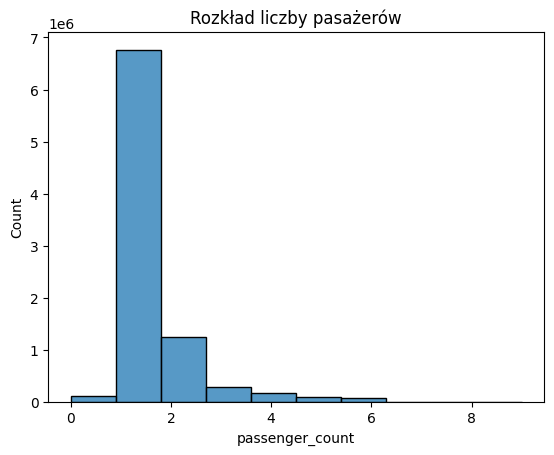

In [40]:
pu.histogram(df=df, col='passenger_count', title='Rozkład liczby pasażerów', bins=10, log_scale=False)

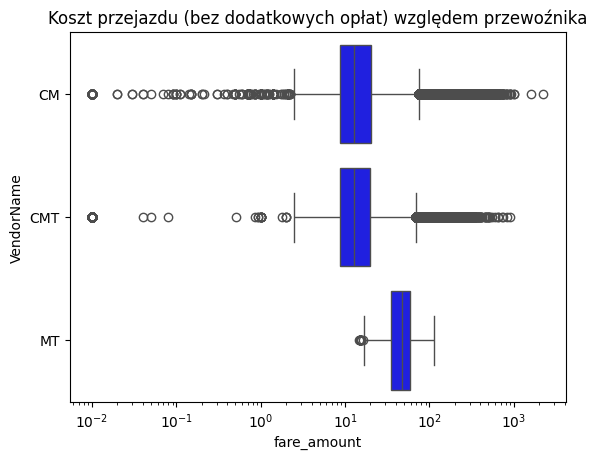

In [41]:
pu.boxplot(df, x='fare_amount', y='VendorName', title='Koszt przejazdu (bez dodatkowych opłat) względem przewoźnika', log_scale=True)

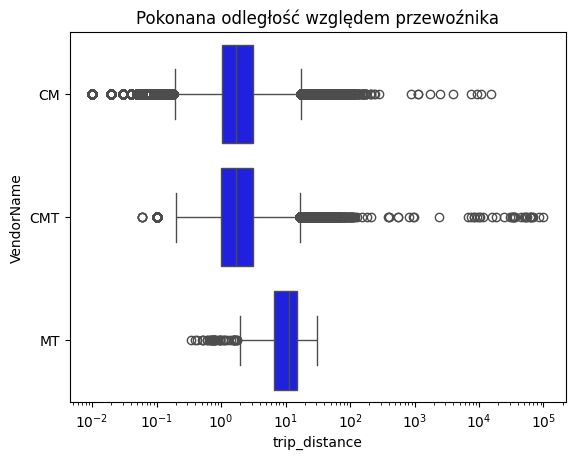

In [42]:
pu.boxplot(df, x='trip_distance', y='VendorName', title='Pokonana odległość względem przewoźnika', log_scale=True)

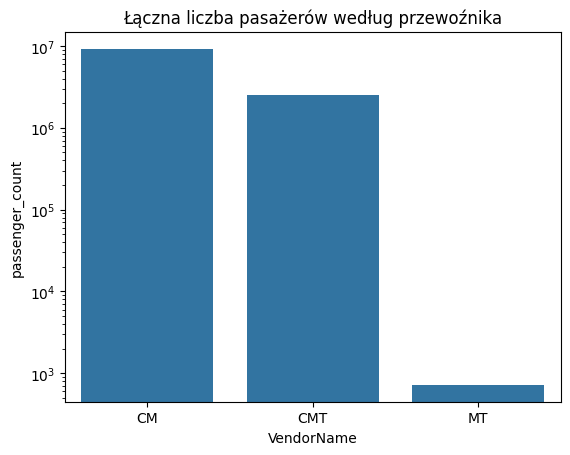

In [43]:
pu.barplot(passenger_sum, x='VendorName', y='passenger_count', title='Łączna liczba pasażerów według przewoźnika', log_y=True)

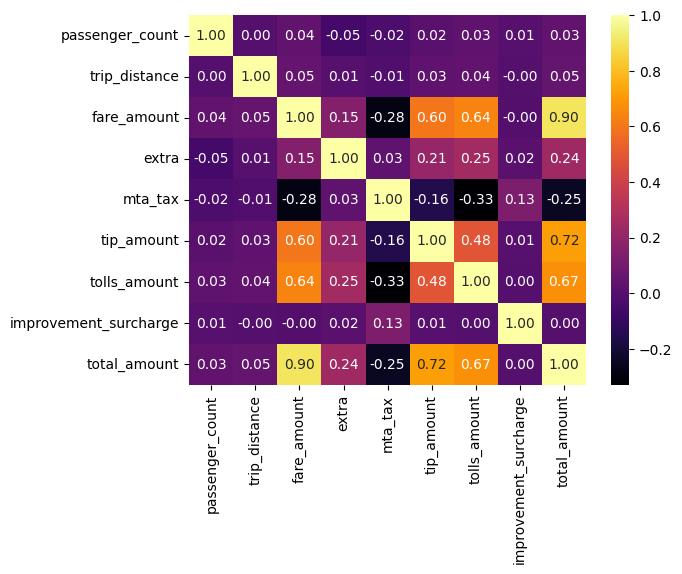

In [44]:
corr_matrix = df[numeric_col_list].corr(numeric_only=True)
pu.corr_heatmap(corr_matrix)

In [52]:
from scipy.stats import shapiro

In [54]:
# Lista zmiennych ciągłych do testowania
columns_to_test = ['trip_distance', 'fare_amount', 'tip_amount', 'extra']

for col in columns_to_test:
    stat, p = shapiro(df[col])
    if p < 0.05:
        print(f"Rozkład zmiennej {col} nie jest zgodny z rozkładem normalnym (p < 0.05).")
    else:
        print(f"Rozkład zmiennej {col} jest zgodny z rozkładem normalnym (p >= 0.05).")

C:\Users\ratch\Desktop\ds360-task-pmk\ds360-task-pmk\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8728302.
  res = hypotest_fun_out(*samples, **kwds)


Rozkład zmiennej trip_distance nie jest zgodny z rozkładem normalnym (p < 0.05).
Rozkład zmiennej fare_amount nie jest zgodny z rozkładem normalnym (p < 0.05).
Rozkład zmiennej tip_amount nie jest zgodny z rozkładem normalnym (p < 0.05).
Rozkład zmiennej extra nie jest zgodny z rozkładem normalnym (p < 0.05).


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, PredictionErrorDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

In [3]:
df = pd.read_csv('nyc_yellow_taxi_clean.csv')
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,pickup_minute,pickup_second,dropoff_day,dropoff_weekday,dropoff_month,dropoff_year,dropoff_hour,dropoff_minute,dropoff_second,seconds_between_dates
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,186,79,2,17.70,1.0,...,57,55,1,0,1,2024,1,17,43,1188.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,140,236,1,10.00,3.5,...,3,0,1,0,1,2024,0,9,36,396.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,236,79,1,23.30,3.5,...,17,6,1,0,1,2024,0,35,1,1075.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,79,211,1,10.00,3.5,...,36,38,1,0,1,2024,0,44,56,498.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,211,148,1,7.90,3.5,...,46,51,1,0,1,2024,0,52,57,366.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8728297,6,2024-03-31 09:03:23,2024-03-31 09:03:32,1.0,1.78,265,142,0,23.20,0.5,...,3,23,31,6,3,2024,9,3,32,9.0
8728298,6,2024-03-31 09:03:59,2024-03-31 10:03:10,1.0,8.37,265,232,0,37.31,0.5,...,3,59,31,6,3,2024,10,3,10,3551.0
8728299,6,2024-03-31 09:03:27,2024-03-31 10:03:46,1.0,4.25,265,73,0,29.20,0.5,...,3,27,31,6,3,2024,10,3,46,3619.0
8728300,6,2024-03-31 13:03:56,2024-03-31 14:03:30,1.0,12.74,265,131,0,40.67,0.0,...,3,56,31,6,3,2024,14,3,30,3574.0


In [42]:
# Wybór zmiennych
features = ['passenger_count', 'trip_distance', 'mta_tax', 'tip_amount', 'extra']
target = 'fare_amount'

# Podział danych
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Model
model = RandomForestRegressor(max_depth=2, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=42)

In [44]:
# Predykcje
y_pred = model.predict(X_test)

# Ocena
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

MAE: 4.20
R²: 0.7877


In [45]:
linear_model = LinearRegression().fit(X_train, y_train)

In [46]:
# Predykcje
linear_y_pred = linear_model.predict(X_test)

# Ocena
linear_mae = mean_absolute_error(y_test, linear_y_pred)
linear_r2 = r2_score(y_test, linear_y_pred)

print(f"MAE: {linear_mae:.2f}")
print(f"R²: {linear_r2:.4f}")

MAE: 8.05
R²: 0.4059


In [47]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
mlp_model = MLPRegressor(random_state=1, max_iter=2000, tol=0.1)
mlp_model.fit(X_train_scaled, y_train)

MLPRegressor(max_iter=2000, random_state=1, tol=0.1)

In [49]:
# Predykcje
mlp_y_pred = mlp_model.predict(X_test_scaled)

# Ocena
mlp_mae = mean_absolute_error(y_test, mlp_y_pred)
mlp_r2 = r2_score(y_test, mlp_y_pred)

print(f"MAE: {mlp_mae:.2f}")
print(f"R^2: {mlp_r2:.2f}")

MAE: 2.17
R^2: 0.91


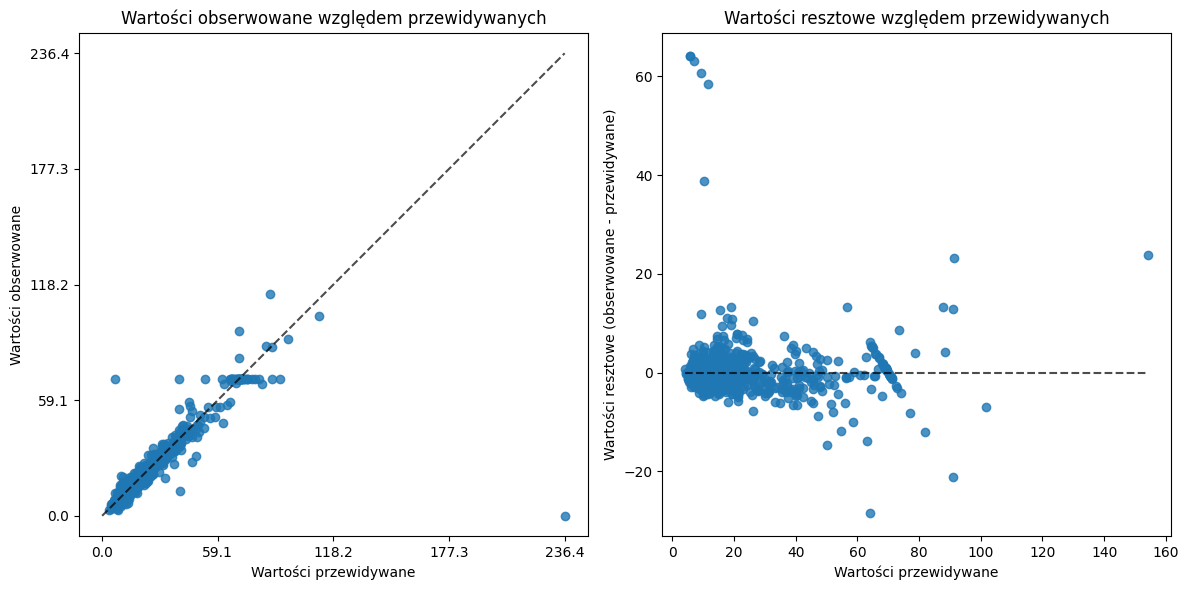

In [50]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=mlp_y_pred, kind='actual_vs_predicted', ax=axes[0])
axes[0].set_title("Wartości obserwowane względem przewidywanych")
axes[0].set_xlabel("Wartości przewidywane")
axes[0].set_ylabel("Wartości obserwowane")
PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=mlp_y_pred, ax=axes[1])
axes[1].set_title("Wartości resztowe względem przewidywanych")
axes[1].set_xlabel("Wartości przewidywane")
axes[1].set_ylabel("Wartości resztowe (obserwowane - przewidywane)")
plt.tight_layout()
plt.show()

In [51]:
df_encoded = pd.get_dummies(df, columns=['VendorName'], drop_first=True)
ext_features = features + ['VendorName_CMT', 'VendorName_MT']

In [53]:
# Podział danych
ext_X = df_encoded[ext_features]
ext_y = df_encoded[target]
ext_X_train, ext_X_test, ext_y_train, ext_y_test = train_test_split(ext_X, ext_y, test_size=0.2, random_state=42)

In [54]:
ext_X_train_scaled = scaler.fit_transform(ext_X_train)
ext_X_test_scaled = scaler.transform(ext_X_test)

In [55]:
ext_mlp_model = MLPRegressor(random_state=1, max_iter=2000, tol=0.1)
ext_mlp_model.fit(ext_X_train_scaled, ext_y_train)

MLPRegressor(max_iter=2000, random_state=1, tol=0.1)

In [56]:
# Predykcje
ext_mlp_y_pred = ext_mlp_model.predict(ext_X_test_scaled)

# Ocena
ext_mlp_mae = mean_absolute_error(ext_y_test, ext_mlp_y_pred)
ext_mlp_r2 = r2_score(ext_y_test, ext_mlp_y_pred)

print(f"MAE: {ext_mlp_mae:.2f}")
print(f"R^2: {ext_mlp_r2:.2f}")

MAE: 2.13
R^2: 0.89
